In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
import re
import lightgbm
import random


In [4]:
test_data = pd.read_csv('../data/test.csv')
train_data = pd.read_csv('../data/train.csv')

In [5]:
train = train_data.copy()
test = test_data.copy()

-0.9593187699947071


<AxesSubplot:ylabel='Frequency'>

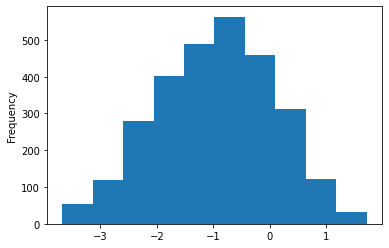

In [6]:
print(train.target.mean())
train.target.plot.hist()

In [7]:
def remove_char(text):
    num = random.randint(15,35)
    num2 = random.randint(0,1)
    
    if num2 == 0:
        return text+text[0:num]
    else:
        return text[:-num]
# ------------------------------------
def target_jitter(df):
    lst = list(zip(df.target, df.standard_error))
    final_lst = []
    for val in lst:
        num = random.randint(0,1)
        error = random.uniform(0, val[1])
        if num ==0:
            final_lst.append(val[0]+error)
        else:
            final_lst.append(val[0]-error)
    df['target'] = final_lst
    return df
    
    
# ------------------------------------
def word_length_counts(text):
    '''
        Return: 
            Dictionry of words length counts 
    '''
    
    d = {"1_letter": 0, 
         "2_letter": 0, 
         "3_letter": 0, 
         "4_letter": 0, 
         "5_letter": 0, 
         "6_letter": 0, 
         "7_letter": 0, 
         "8_letter": 0, 
         "9_letter": 0, 
         "10_letter": 0, 
         "11_letter": 0, 
         "12_letter": 0
    }

    text.replace('\n', '')
    text = text.lower()
    n_text = ''
    for c in text: 
        if c not in punctuation:
            n_text += c
        else: n_text += ' '

    text = n_text
    for word in text.split(' '): 
        wl = len(word)
        if wl > 0:
            if len(word) >= 12: key = f"12_letter"
            else:  key = f"{len(word)}_letter"

            d[key] += 1; 
    return d
# ------------------------------------
def source_info(text):
    '''
        Return: 
            Dictionary of source wiki, article, book, details, story or stories, kid, edu, simple
    '''
    d = dict()
    source_type = ['wiki', 'article', 'book', 'details', 'kid', 'edu', 'simple', 'story', 'stories']
    
    for t in source_type:
        if t != 'stories': 
            d[t] = 0
            
        if t in text:
            if t == 'stories': 
                d['story'] = 1;
            else: d[t] = 1
    return d
# ------------------------------------
def document_info(text):
    '''
        Return:
            Dictionary of document lenght, word count, sentence count, average word lenght
    '''
    text_lenght = len(text)
    text = text.replace('\n', ' ')
    text_word_count = len(text.split(' '))
    text_sentence_count = len(re.split('\.|!|\?',text)) # modified by James
    text = re.split('\.|!|\?',text)
    text_avg_word_length = round(sum([len(t) for t in text]) / text_word_count, 2)

    document_info = {
        'doc_len': text_lenght,
        'word_count': text_word_count,
        'sent_count': text_sentence_count,
        'avg_word_len': text_avg_word_length
    }

    return document_info
#----------------------------------------
def words_per_sentence(text):
   
    total = []
    text = text.replace('Mrs.',"Mrs")
    text = text.replace('Mr.',"Mr")
    text = text.replace('Dr.',"Dr")
    text = text.replace('Capt.',"Capt")
    text = text.replace('U.S.',"U S")
    text = text.replace('U. S.',"U S")
    
    sentences = re.split('\. |! |\? ',text)
    for sentence in sentences: #iterate over list of sentences
        if sentence != '':
            word_list = sentence.split(' ') #split a sentence into list of words
            while("" in word_list):
                word_list.remove("")
            while('"' in word_list):
                word_list.remove('"')
            total.append(len(word_list)) #total number of words in a sentence add to list
    return np.mean(total)
    
# ------------------------------------
def character_counts(text):
    '''
        Return:
            Dictionary of counts of all characters in text
    '''
    char_dict = dict()
    text = text.lower()
    text = text.replace('\n', ' ')
    
    for char in text:
        if char not in char_dict:
            char_dict[char] = 0
        
        char_dict[char] += 1     
        
    return char_dict

# ------------------------------------
def phonemes_counts(text):
    '''
        Return: 
            Dictionay of all phonemic in text
    '''
    phonemes = ['ck', 'cc', 'di', 'nn', 'dd', 'ai', 'ss', 'mn', 'bb', 
                'sci', 'ze', 'qu', 'se', 'sc', 'ci', 'ps', 'si', 'tch', 
                'ngue', 'st', 'gu', 'th', 'pn', 've', 'te', 'zz', 'au', 
                'lm', 'lf', 'ge', 'wh', 'tu', 'wr', 'ph', 'sh', 'mm', 'gh', 
                'dge', 'ft', 'tt', 'ed', 'ng', 'lk', 'ti', 'gue', 'rr', 'ch', 
                'll', 'gn', 'ff', 'gg', 'pp', 'rh', 'ce', 'mb', 'kn', 
                'eer', 'ere', 'uy', 'ho', 'ear', 'ei', 'ar', 'ai', 
                'oor', 'ure', 'eigh', 'ey', 'is', 'ae', 'ow', 'or', 'ew', 
                'ore', 'ur', 'uoy', 'air', 'au', 'ough', 'yr', 
                'ea', 'ayer', 'augh', 'aw', 'eau', 'aigh', 'igh', 'oy', 
                'oo', 'ue', 'are', 'ee', 'oa', 'et', 'y', 'er', 'eir', 
                'oew', 'oar', 'ie', 'eo', 'ui', 'ier', 'ou', 'ir', 'oi', 
                'ay', 'ye', 'oe', 'our']
    temp_dict = dict()
    
    # lower text 
    text = text.lower()
    
    for p in phonemes:
        temp_dict[p] = text.count(p)
    
    return temp_dict

#-----------------------
def add_data(df,float1,float2):
    group = df.loc[(df.target<float1) | (df.target>float2)]
    group = group.copy()
    group['mod'] =  group.excerpt.apply(lambda x: remove_char(x))
    group.drop(columns =['excerpt'],axis = 1,inplace = True)
    group = group.rename(columns = {"mod":"excerpt"})
    target_jitter(group)
    mod_train = pd.concat([df,group],sort = 'False')
    train = mod_train
    return train

In [8]:
train.target.max()

1.7113898269999999

<AxesSubplot:ylabel='Frequency'>

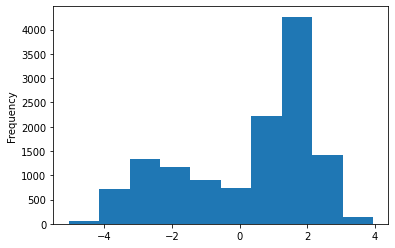

In [9]:
train = add_data(train,-2,1)
train = add_data(train,-3,1)
train = add_data(train,-5,1)
train = add_data(train,-5,1)
train = add_data(train,-5,1)
train = add_data(train,-5,1)
train = add_data(train,-3,1)
train = add_data(train,-2,1)


train.target.plot.hist()

In [10]:
print(train.target.mean())
print(len(train))

0.2551787428189292
12934


In [11]:
#combine train and test set for pre-processing
c_df = pd.concat([train, test], axis = 0)

<ipython-input-11-d070e0ef3f54>:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  c_df = pd.concat([train, test], axis = 0)


In [12]:
c_df

,excerpt,id,license,standard_error,target,url_legal
0,When the young people returned to the ballroom...,c12129c31,NaN,0.464009,-0.340259,NaN
1,"All through dinner time, Mrs. Fayre was somewh...",85aa80a4c,NaN,0.480805,-0.315372,NaN
2,"As Roger had predicted, the snow departed as q...",b69ac6792,NaN,0.476676,-0.580118,NaN
3,And outside before the palace a great garden w...,dd1000b26,NaN,0.450007,-1.054013,NaN
4,Once upon a time there were Three Bears who li...,37c1b32fb,NaN,0.510845,0.247197,NaN
...,...,...,...,...,...,...
2,It was a bright and cheerful scene that greete...,0df072751,NaN,NaN,NaN,NaN
3,Cell division is the process by which a parent...,04caf4e0c,CC BY-SA 3.0,NaN,NaN,https://en.wikipedia.org/wiki/Cell_division
4,Debugging is the process of finding and resolv...,0e63f8bea,CC BY-SA 3.0,NaN,NaN,https://en.wikipedia.org/wiki/Debugging
5,"To explain transitivity, let us look first at ...",12537fe78,NaN,NaN,NaN,NaN


In [13]:
series_documents =  c_df.excerpt.apply(lambda x: document_info(x))
series_phonemes = c_df.excerpt.apply(lambda x: phonemes_counts(x))
series_characters =  c_df.excerpt.apply(lambda x: character_counts(x))
series_word_length = c_df.excerpt.apply(lambda x: word_length_counts(x))
series_word_per_sent = c_df.excerpt.apply(lambda x: words_per_sentence(x))

In [14]:
df_documents = pd.DataFrame(list(series_documents))
df_phonemes = pd.DataFrame(list(series_phonemes))
df_chracters = pd.DataFrame(list(series_characters))
df_word_length = pd.DataFrame(list(series_word_length))
df_word_per_sent = pd.DataFrame(list(series_word_per_sent))
df_word_per_sent.rename(columns={0:'wps'}, inplace = True)

In [15]:
# Make na 0
df_chracters.fillna(0, inplace = True)
#df_chracters_test.fillna(0, inplace = True)


# Make all ints (change NaN to 0)
for col in df_chracters.columns:
    df_chracters[col] = df_chracters[col].astype(int, copy=False)

#for col in df_chracters_test.columns:
#    df_chracters_test[col] = df_chracters_test[col].astype(int, copy=False)


In [16]:
df_dialogue = pd.DataFrame(list(c_df.excerpt.str.contains("\".*\"",regex = True).astype(int)))
df_dialogue.rename(columns = {0:'dialogue'},inplace = True)

In [17]:
df_X = pd.concat([df_documents, df_phonemes, df_word_length,df_word_per_sent,df_dialogue], axis = 1)
#df_X_test = pd.concat([df_documents_test, df_phonemes_test, df_word_lenght_test], axis = 1)

In [18]:
df_X

,doc_len,word_count,sent_count,avg_word_len,ck,cc,di,nn,dd,ai,...,5_letter,6_letter,7_letter,8_letter,9_letter,10_letter,11_letter,12_letter,wps,dialogue
0,992,179,12,5.48,1,0,1,0,0,1,...,21,10,9,10,8,3,0,0,29.000000,0
1,937,169,18,5.44,0,0,1,1,1,3,...,17,15,12,5,2,5,2,0,20.500000,1
2,908,166,13,5.40,3,1,1,1,1,4,...,24,7,11,9,3,2,0,0,27.000000,1
3,909,164,6,5.51,0,0,0,0,0,3,...,21,20,15,4,1,1,0,1,40.750000,0
4,723,147,6,4.88,0,0,0,0,7,4,...,28,14,0,2,0,0,0,0,29.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12936,948,174,14,5.37,0,0,2,1,0,5,...,14,18,11,11,3,1,0,0,33.600000,1
12937,1144,182,8,6.25,0,1,13,0,0,0,...,19,11,18,23,6,9,7,1,35.800000,0
12938,1094,168,7,6.48,2,0,5,0,0,0,...,18,11,26,8,18,6,6,0,33.400000,1
12939,823,148,10,5.50,0,0,2,0,0,1,...,7,12,17,3,2,0,3,3,16.444444,0


In [19]:
df_X = df_X.T.drop_duplicates().T
# df_X_test = df_X_test.T.drop_duplicates().T


In [20]:
df_X_test = df_X.iloc[-len(test):]
df_X = df_X.iloc[:-len(test)]
df_y = c_df['target'][:-len(test)]

<h1>Standardize Data

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate

scaler = MinMaxScaler()
print(scaler.fit(df_X))
# print(scaler.data_max_)
x_train = scaler.transform(df_X)



MinMaxScaler(copy=True, feature_range=(0, 1))


<h1> Fitting Models

In [22]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# #LightGBM
# model = LGBMRegressor(n_estimators = 200, max_depth = 90, reg_alpha = .1)

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # reg_alpha
# reg_alpha = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'reg_alpha': reg_alpha
#               }
# lgbm = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# lgbm.fit(x_train, df_y.values)

# lgbm.best_params_

# model.fit(x_train,df_y)
# predictions = model.predict(x_train)
# print(mean_squared_error(df_y, predictions, squared=False))
# cv_results = cross_validate(model, x_train, df_y.values, cv=5, scoring = 'neg_mean_squared_error')


# #Random Forest
# model_rfr = RandomForestRegressor(n_estimators = 500, )
# model_rfr.fit(x_train,df_y)
# predictions = model_rfr.predict(x_train)
# print(mean_squared_error(df_y, predictions, squared=False))
# cv_results_rfr = cross_validate(model_rfr, x_train, df_y.values, cv=5, scoring = 'neg_mean_squared_error')
# print(cv_results_rfr['test_score'])


In [23]:
# print(cv_results['test_score'])
# x_test = scaler.transform(df_X_test)
# y_predict = model.predict(x_test)
# y_predict

In [24]:
#random forest model
model_rfr = RandomForestRegressor(n_estimators = 500)
model_rfr.fit(x_train,df_y)
predictions = model_rfr.predict(x_train)
print(mean_squared_error(df_y, predictions, squared=False))
cv_results_rfr = cross_validate(model_rfr, x_train, df_y.values, cv=5, scoring = 'neg_mean_squared_error')
print(cv_results_rfr['test_score'])


0.22874888833661247
[-1.33134282 -0.2141913  -0.24423965 -0.2393836  -0.37373511]


default LGBM was .33489

0.20189421949665898

[-0.67757485 -0.29058851 -0.21928215 -0.22328962 -0.17938408]

0.19931558921802858

[-0.64393856 -0.27008002 -0.22100026 -0.22946819 -0.23954556]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: min_samples_split
{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

<h1>Submission

In [ ]:
#LightGBM
# x_test = scaler.transform(df_X_test)
# y_predict = model.predict(x_test)
# y_predict

In [ ]:
# #RFR
# x_test = scaler.transform(df_X_test)
# y_predict_rfr = model_rfr.predict(x_test)
# y_predict_rfr


In [ ]:
# avg_result = (y_predict_rfr + y_predict)/2
# avg_result

In [ ]:
submission = pd.DataFrame(y_predict)


In [ ]:
submission['id'] = test.id.values
submission = submission.rename(columns = {0:'target'})
submission = submission[['id','target']]
submission.reset_index(drop=True, inplace=True)

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
test.excerpt.iloc[6]

In [ ]:
train[(train['target']>0) & (train['target']<.5)]['excerpt'].iloc[2]

In [ ]:
train.excerpt.iloc[240]